## Workflow to analyze pyControl data



```batch script
jupyter nbconvert "D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20221005_210000_workflow_pyCon_PavAll.ipynb" --to="python" --output-dir="D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical" --output="nb20221005_210000_workflow_pyCon_PavAll"
```

### Imports

In [1]:
# Import Session and Experiment class with helper functions
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Variables

In [2]:
import pandas as pd

trial_window = [-2000, 6000] # in ms


# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.path.split(os.getcwd())[0])

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params/tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

### Tasks
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)
- To analyze a new task you need to append task characteristics like **task** filename, **triggers**, **events** and **conditions**

In [3]:
tasks = pd.read_csv(tasksfile, usecols = [1,2,3,4], index_col = False)
tasks

,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


# Optional

1m 7s

In [4]:
photo_root_dir = 'T:\\Data\\head-fixed\\pyphotometry\\data'
pycontrol_root_dir = 'T:\\Data\\head-fixed\\pycontrol'

root_folders = [photo_root_dir, pycontrol_root_dir]
horizontal_folder_pycontrol = 'T:\\Data\\head-fixed\\test_folder\\pycontrol'
horizontal_folder_photometry = 'T:\\Data\\head-fixed\\test_folder\\photometry'

copy_files_to_horizontal_folders(
    root_folders, horizontal_folder_pycontrol, horizontal_folder_photometry)


### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [5]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
# pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')
pycontrol_files_path = r'T:\Data\head-fixed\kms_pycontrol'
# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)

# Only use if the Experiment cohort as been processed by trials before
# TODO: assess whether this can be removed or not
exp_cohort.by_trial = True

Saved sessions loaded from: sessions.pkl


## retain only pavlovian sessions

In [6]:
exp_cohort.sessions = exp_cohort.get_sessions(task_names='pavlovian_nobar_nodelay')
# exp_cohort.save()
print(len(exp_cohort.sessions ))
exp_cohort.subject_IDs



175


[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]

### Perform extraction of behavioural information by trial

3m 7.6s

In [7]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, 
  blank_spurious_event='spout', blank_timelim=[0, 65])

# Save the file as sessions.pkl in folder_path
# exp_cohort.save()

No event  'spout'  found:  45 2022-04-27 15:57:48 pavlovian_nobar_nodelay
No event  'spout'  found:  42 2022-04-28 12:53:21 pavlovian_nobar_nodelay
No event  'spout'  found:  45 2022-05-06 12:27:18 pavlovian_nobar_nodelay
file too short to process (likely aborted session):                 45 2022-05-17 17:02:55 pavlovian_nobar_nodelay
No event  'spout'  found:  47 2022-07-25 17:06:18 pavlovian_nobar_nodelay
No event  'bar'  found:  48 2022-07-25 17:06:18 pavlovian_nobar_nodelay
No event  'bar_off'  found:  48 2022-07-25 17:06:18 pavlovian_nobar_nodelay
No event  'spout'  found:  48 2022-07-25 17:06:18 pavlovian_nobar_nodelay
No event  'spout'  found:  48 2022-07-25 17:07:44 pavlovian_nobar_nodelay
No event  'spout'  found:  50 2022-07-25 17:26:51 pavlovian_nobar_nodelay
No event  'spout'  found:  53 2022-07-25 17:44:00 pavlovian_nobar_nodelay
No event  'bar'  found:  49 2022-07-26 15:19:52 pavlovian_nobar_nodelay
No event  'bar_off'  found:  49 2022-07-26 15:19:52 pavlovian_nobar_nodel

In [8]:
len(exp_cohort.sessions)

169

In [9]:
exp_cohort.sessions[1].df_events.head(50)

,timestamp,trigger,valid,success,bar_trial_time,bar_off_trial_time,spout_trial_time
trial_nb,,,,,,,
1,6936,CS_Go,True,False,[],[],[]
2,20983,CS_Go,True,False,[],[],[]
3,33870,CS_Go,True,False,[],[],[]
4,45328,CS_Go,True,False,[],[],[]
5,57113,CS_Go,True,False,[],[],[]
6,71378,CS_Go,True,False,[],[],[]
7,83341,CS_Go,True,False,[],[],[]
8,97328,CS_Go,True,False,[],[],[]
9,108286,CS_Go,True,False,[],[],[]


# Define conditions and groups for extraction

## Pavlovian

In [10]:
# List of uncued conditions as listed on the tasks .csv file for task pavlovian_nobar_nodelay:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'success': True}
conditions_dict1 = {'success': False}


# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1]
# Aliases for conditions
cond_aliases = ['Hit', 'Miss']
# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]


In [11]:
exp_cohort.sessions

Behaviour: Create a dataset

In [12]:
ev_dataset = exp_cohort.behav_events_to_dataset(
        groups = groups,
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names='pavlovian_nobar_nodelay',
        trig_on_ev = None)

ev_dataset.set_trial_window(trial_window=trial_window, unit='milliseconds')
ev_dataset.set_conditions(conditions=condition_list, aliases=cond_aliases)


Behaviour: Compute distribution

In [13]:
dist_as_continuous = ev_dataset.compute_distribution(
    trial_window=trial_window,
        bin_size = 100, # do not work as expected with cued-uncued
        normalize = True,
        per_session = True,
        out_as_continuous = True)
dist_as_continuous.set_conditions(conditions=condition_list, aliases=cond_aliases)
# Remove test files
dist_as_continuous.filterout_subjects([0,1])


### Optional methods

- Implementation of these optional filtering options is first understood as removing subjects, groups, conditions...
- It is a non-permanent way of discarding elements for analysis
- It is based on a "keep" column in the metadata that is True by default and set to False with the filtering function.
- At anytime, <trial_dataset>.filter_reset() can be called to re-include all the elements in the analysis (set all "keep" to True)
- Comment or uncomment lines and fill the lists according to your needs

In [14]:
# # Get a list of the groups
# dist_as_continuous.get_groups()
# # Get a list of the variables
# dist_as_continuous.get_col_names()

# # reset previous filtering of the dataset
# dist_as_continuous.filter_reset()

# # exclude some conditions by IDs
# dist_as_continuous.filterout_conditions([])

# # exclude some groups by IDs
# dist_as_continuous.filterout_groups([])

# # exclude some subjects
# dist_as_continuous.filterout_subjects([0, 1])
# #     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# # filter subjects/sessions with less than x trials (by condition)
# dist_as_continuous.filter_min(min_trials = 1)

# # To remove subjects who do not have trials
# # in all the conditions, if called after filter_min(),
# # will discard any subject who do not have the minimum number
# # of trials in all the conditions

# # dist_as_continuous.filter_if_not_in_all_cond()


Indicative preview of the behavioural metadata

In [15]:
dist_as_continuous.metadata_df.head(50)

,condition_ID,group_ID,subject_ID,session_nb,bar_trial_time,bar_off_trial_time,spout_trial_time,trial_ID,bar_dist,bar_off_dist,spout_dist,keep
0,0,0,41,2,"[55.0, 1481.0, 1701.0, 2131.0, 4888.0, 113.0, ...","[1409.0, 1504.0, 1943.0, 2176.0, 4903.0, 128.0...","[1011, 113, 8314, 9147, -940, -534, 124, 496, ...",0,"[0.3333333333333333, 0.0, 0.6666666666666666, ...","[0.0, 0.0, 1.3333333333333333, 0.3333333333333...","[0.0, 0.0, 0.6666666666666666, 0.3333333333333...",True
1,0,0,41,4,"[-522.0, 647.0, 2347.0, 3554.0, 4233.0, 4897.0...","[-614.0, 462.0, 662.0, 2362.0, 3570.0, 4248.0,...","[-583, 93, 67, 196, 248, 647, 2347, 3554, 4233...",1,"[0.1388888888888889, 0.0, 0.1388888888888889, ...","[0.1388888888888889, 0.1388888888888889, 0.138...","[0.1388888888888889, 0.0, 0.1388888888888889, ...",True
2,0,0,41,5,"[5127.0, 5314.0, 3559.0, -1078.0, 107.0, 6905....","[5014.0, 5245.0, 2918.0, -1830.0, 71.0, 128.0,...","[533, 707, 1033, 282, 2679, 4391, 4888, -326, ...",2,"[0.18518518518518517, 0.0, 0.0, 0.185185185185...","[0.37037037037037035, 0.18518518518518517, 0.0...","[0.18518518518518517, 0.0, 0.0, 0.185185185185...",True
3,0,0,41,6,"[242.0, 2857.0, 3616.0, 4276.0, 4914.0, 4940.0...","[227.0, 257.0, 3449.0, 4210.0, 4868.0, 4929.0,...","[502, 1913, 513, 1920, 3086, 366, 1815, 3214, ...",3,"[0.058823529411764705, 0.0, 0.0588235294117647...","[0.058823529411764705, 0.0, 0.0, 0.05882352941...","[0.29411764705882354, 0.11764705882352941, 0.1...",True
4,0,0,41,7,"[192.0, 1154.0, 3306.0, -930.0, -704.0, 4331.0...","[1106.0, 1233.0, -994.0, -749.0, 171.0, 4363.0...","[1438, 2126, 2512, 2661, 2771, -42, 335, 509, ...",4,"[0.39603960396039606, 0.49504950495049505, 0.2...","[0.39603960396039606, 0.39603960396039606, 0.2...","[0.0, 0.297029702970297, 0.297029702970297, 0....",True
5,0,0,41,8,"[3756.0, 3752.0, 3806.0, 5669.0, 5916.0, 161.0...","[243.0, -593.0, 3767.0, 181.0, 5893.0, -1132.0...","[482, 1800, 2595, 3003, 3283, -255, 384, 1766,...",5,"[0.3067484662576687, 0.12269938650306748, 0.0,...","[0.06134969325153374, 0.06134969325153374, 0.1...","[0.18404907975460122, 0.3067484662576687, 0.18...",True
6,0,0,42,1,"[1421, 2388, 2408, 9158, 9178, 9238, 9258, 927...","[1436, 2403, 2423, 9173, 9193, 9253, 9273, 929...",[68],6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
7,0,0,42,2,[],[],[519],7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
8,0,0,42,4,"[678.0, 732.0, 1242.0, 1714.0, 2091.0, 2125.0,...","[245.0, 712.0, 1227.0, 1328.0, 1729.0, 2106.0,...","[1487, 1855, 193, 755, 967, 5506, 5526, 5546, ...",8,"[0.5, 0.0, 2.0, 1.0, 0.0, 0.5, 0.5, 0.5, 1.0, ...","[0.5, 0.0, 2.0, 0.5, 1.0, 0.5, 1.0, 0.0, 1.0, ...","[1.0, 0.5, 0.0, 1.5, 0.5, 0.5, 2.0, 0.5, 2.5, ...",True
9,0,0,42,5,"[-2.0, 391.0, 435.0, 486.0, 594.0, 667.0, 707....","[13.0, 406.0, 471.0, 579.0, 609.0, 682.0, 1578...","[80, 283, 1135, -823, -580, 469, 1103, 320, -1...",9,"[0.0, 1.3043478260869565, 3.0434782608695654, ...","[1.3043478260869565, 0.8695652173913043, 2.173...","[0.0, 0.0, 1.3043478260869565, 0.4347826086956...",True


## Behaviour: Plot distribution

#TODO what is T = 0?
How to plot differently? Or not necessary?

True    315
Name: keep, dtype: int64

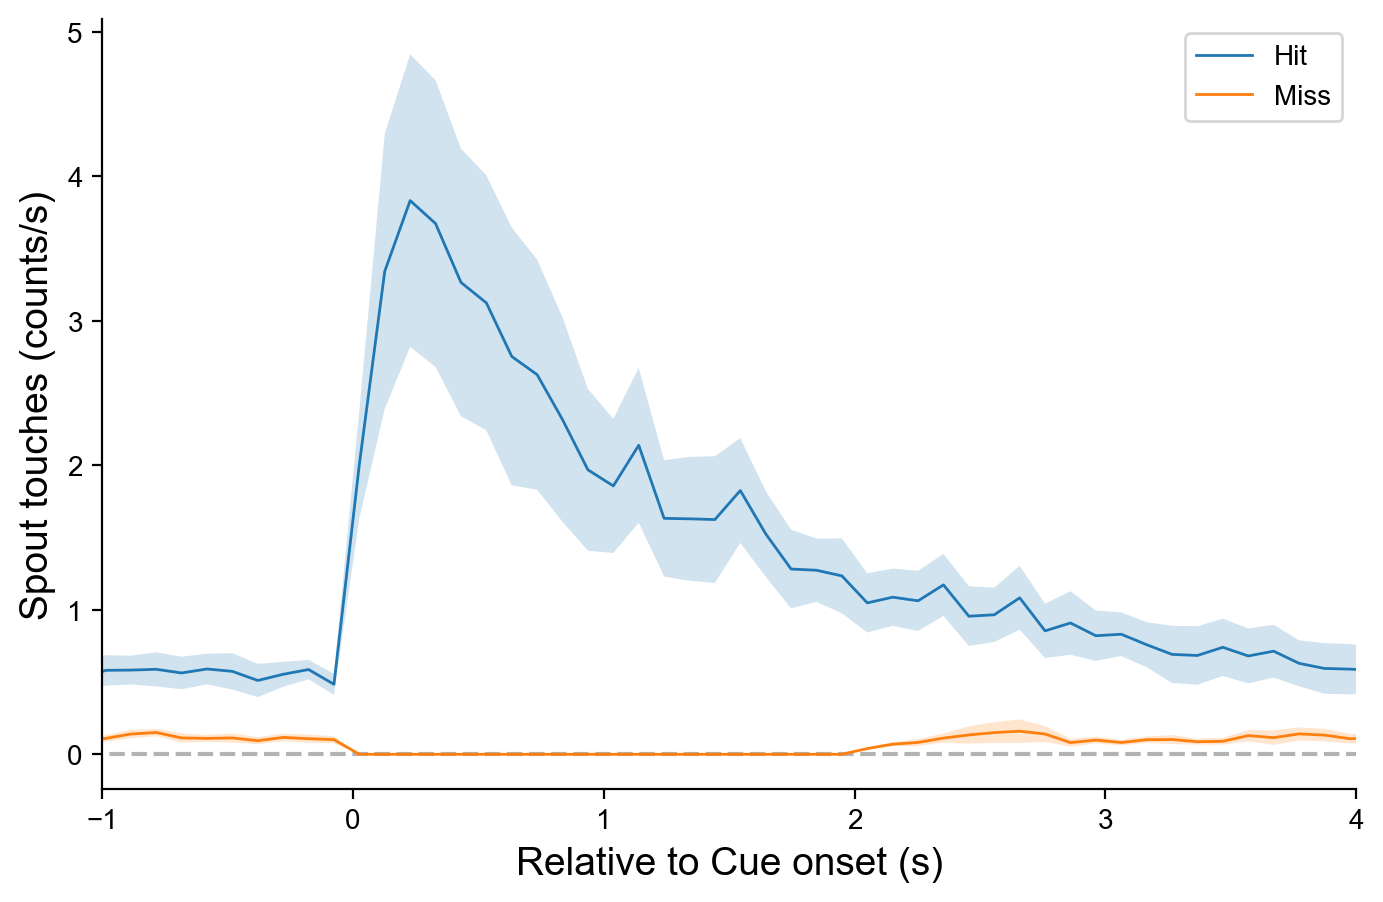

In [16]:
import trialexp.utils.pycontrol_utilities as pycutl

dist_as_continuous.set_trial_window([a/1000 for a in trial_window], 's')

figs, axs, df1 = dist_as_continuous.lineplot(
    vars = [ 'spout_dist'],
    time_lim = [-1,4],
    time_unit='s',
    error = True,
    ylim = None,#[[-0.1,1.6]], #[[-0.1, 0.7]], #[[-0.1, 1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = pycutl.cmap10(),
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5*1.618, 5),
    dpi = 200,
    verbose = False)


axs[0, 0].set_xlabel('Relative to Cue onset (s)', fontsize=14) #TODO not sure
axs[0, 0].set_ylabel('Spout touches (counts/s)', fontsize=14) #TODO not sure
# Return a count of overall number of trials
dist_as_continuous.metadata_df['keep'].value_counts()


## Success Rate computation

65 ms window for spout touch

df_events.spout_trial_time < 65

`Session.compute_success()` does this

and is inherited to `ev_dataset.meatadata_df` and `ev_dataset.data`





### By Days, Dates, or By Sessions?


### sessions

     group_ID  subject_ID  session_nb  success_n  failure_n  trial_n  \
0           0          41           1          0         66       66   
1           0          41           2         30         97      127   
2           0          41           3          0        159      159   
3           0          41           4         72        112      184   
4           0          41           5         54        137      191   
..        ...         ...         ...        ...        ...      ...   
164         0          53          18         41        135      176   
165         0          53          19         38         57       95   
166         0          53          20         28        173      201   
167         0          53          21        101         71      172   
168         0          53          22        138         34      172   

     success_rate            datetime        date  
0        0.000000 2022-04-26 16:35:36  2022-04-26  
1        0.236220 2022-04-27 14

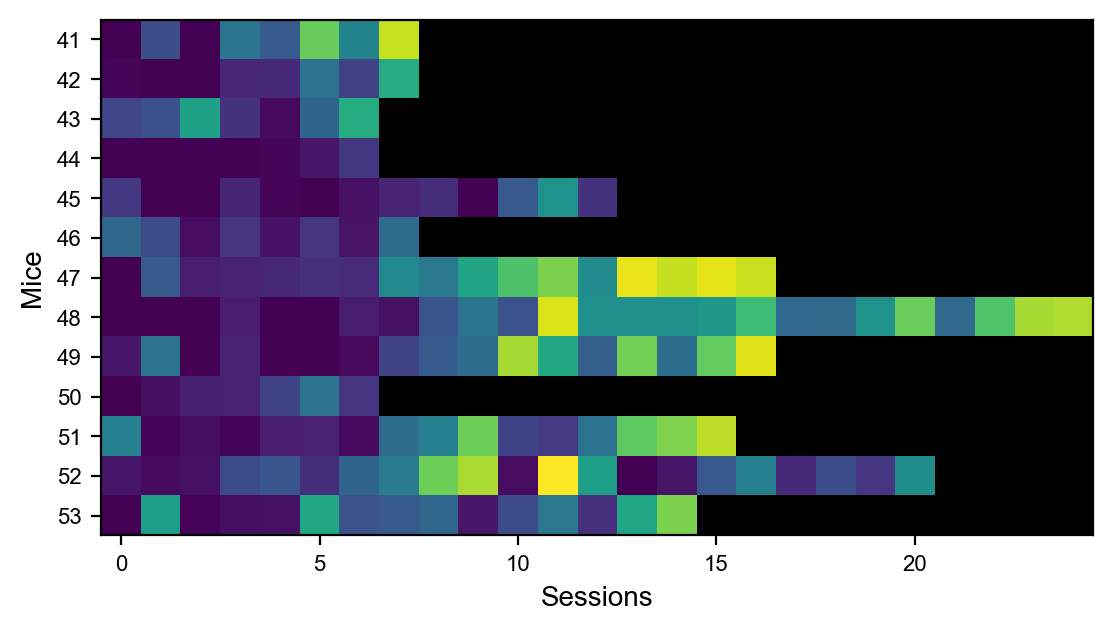

In [26]:
gr_df, out_list, _, _ = ev_dataset.analyse_successrate(
    [0], [1], bywhat='sessions')

print(gr_df)

print(out_list)


### sessions with gaps

     group_ID  subject_ID  session_nb  success_n  failure_n  trial_n  \
0           0          41           1          0         66       66   
1           0          41           2         30         97      127   
2           0          41           3          0        159      159   
3           0          41           4         72        112      184   
4           0          41           5         54        137      191   
..        ...         ...         ...        ...        ...      ...   
164         0          53          18         41        135      176   
165         0          53          19         38         57       95   
166         0          53          20         28        173      201   
167         0          53          21        101         71      172   
168         0          53          22        138         34      172   

     success_rate            datetime        date  
0        0.000000 2022-04-26 16:35:36  2022-04-26  
1        0.236220 2022-04-27 14

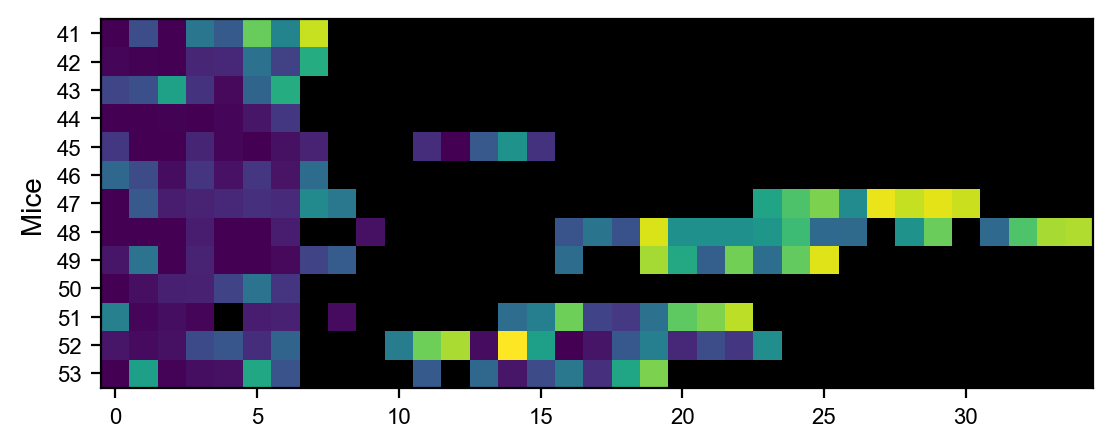

In [27]:
gr_df, out_list, _, _ = ev_dataset.analyse_successrate(
    [0], [1], bywhat='sessions_with_gaps')

print(gr_df)

print(out_list)


### days

     group_ID  subject_ID  session_nb  success_n  failure_n  trial_n  \
0           0          41           1          0         66       66   
1           0          41           2         30         97      127   
2           0          41           3          0        159      159   
3           0          41           4         72        112      184   
4           0          41           5         54        137      191   
..        ...         ...         ...        ...        ...      ...   
164         0          53          18         41        135      176   
165         0          53          19         38         57       95   
166         0          53          20         28        173      201   
167         0          53          21        101         71      172   
168         0          53          22        138         34      172   

     success_rate            datetime        date  
0        0.000000 2022-04-26 16:35:36  2022-04-26  
1        0.236220 2022-04-27 14

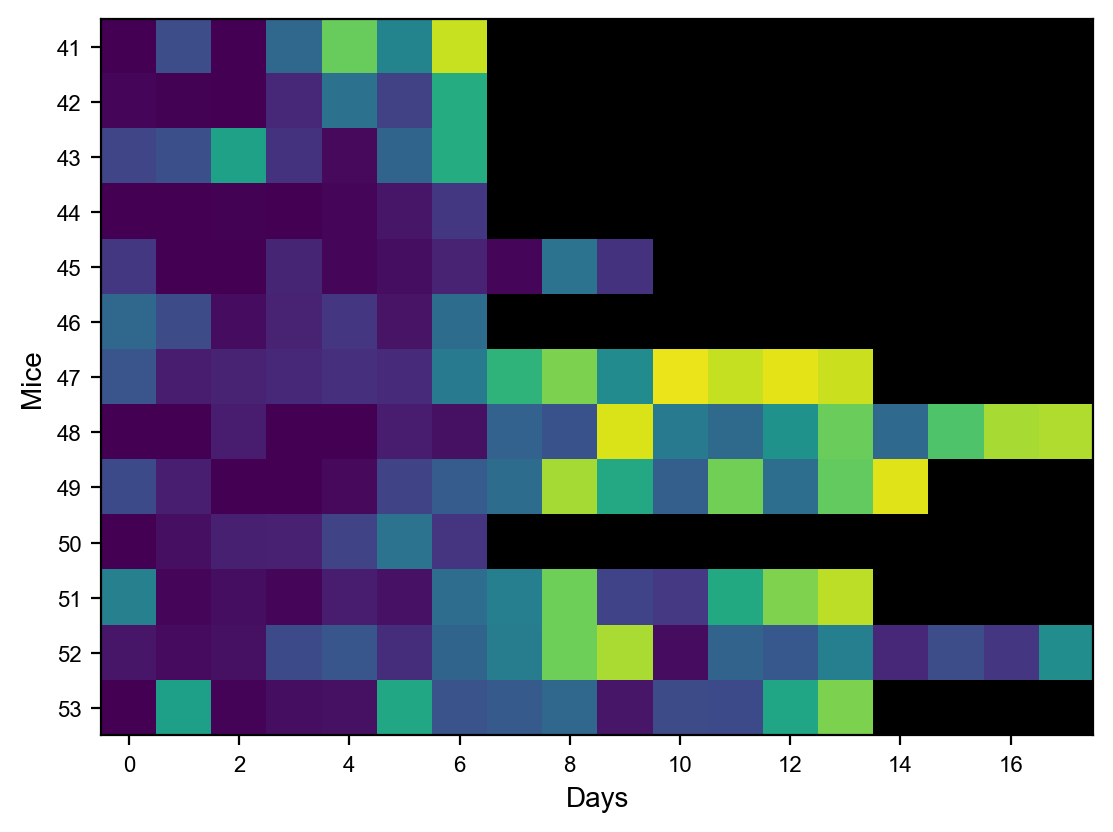

In [28]:
gr_df, out_list, _, _ = ev_dataset.analyse_successrate([0], [1], bywhat='days')

print(gr_df)

print(out_list)


### days_with_gaps

     group_ID  subject_ID  session_nb  success_n  failure_n  trial_n  \
0           0          41           1          0         66       66   
1           0          41           2         30         97      127   
2           0          41           3          0        159      159   
3           0          41           4         72        112      184   
4           0          41           5         54        137      191   
..        ...         ...         ...        ...        ...      ...   
164         0          53          18         41        135      176   
165         0          53          19         38         57       95   
166         0          53          20         28        173      201   
167         0          53          21        101         71      172   
168         0          53          22        138         34      172   

     success_rate            datetime        date  
0        0.000000 2022-04-26 16:35:36  2022-04-26  
1        0.236220 2022-04-27 14

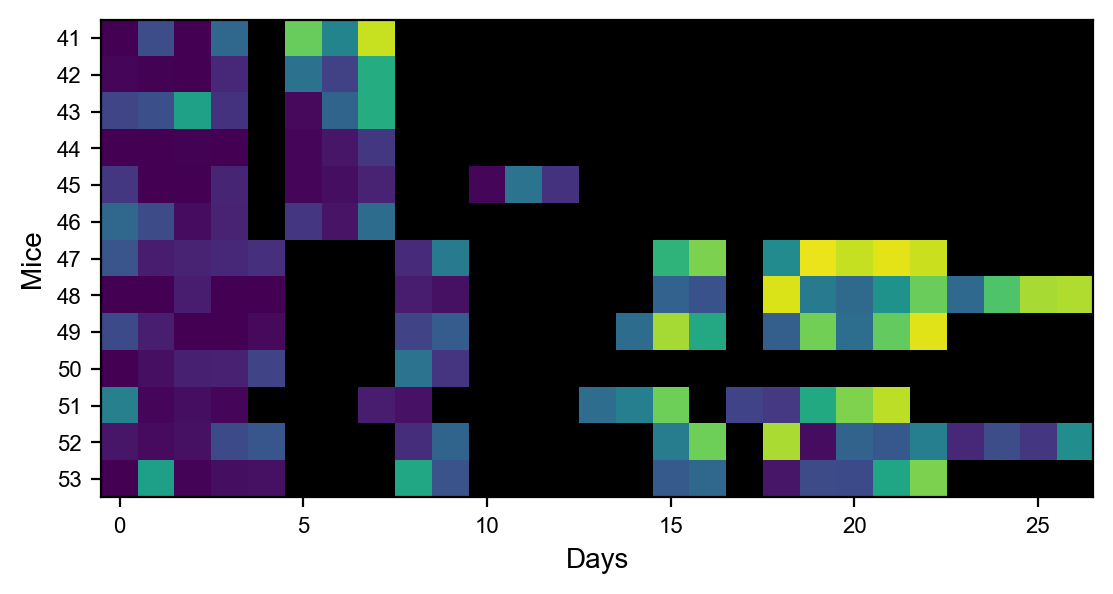

In [29]:
gr_df, out_list, _, _ = ev_dataset.analyse_successrate(
    [0], [1], bywhat='days_with_gaps')

print(gr_df)

print(out_list)


### Dates

In [30]:
out_list[0].index


TimedeltaIndex([ '0 days',  '1 days',  '2 days',  '3 days',  '4 days',
                 '7 days', '10 days', '13 days', '14 days', '15 days',
                '21 days', '23 days', '24 days', '30 days', '31 days',
                '32 days', '33 days', '50 days', '51 days', '52 days',
                '53 days', '54 days', '55 days', '56 days', '57 days',
                '58 days', '59 days'],
               dtype='timedelta64[ns]', name='dayN', freq=None)

     group_ID  subject_ID  session_nb  success_n  failure_n  trial_n  \
0           0          41           1          0         66       66   
1           0          41           2         30         97      127   
2           0          41           3          0        159      159   
3           0          41           4         72        112      184   
4           0          41           5         54        137      191   
..        ...         ...         ...        ...        ...      ...   
164         0          53          18         41        135      176   
165         0          53          19         38         57       95   
166         0          53          20         28        173      201   
167         0          53          21        101         71      172   
168         0          53          22        138         34      172   

     success_rate            datetime        date  
0        0.000000 2022-04-26 16:35:36  2022-04-26  
1        0.236220 2022-04-27 14

[Text(0, 0, '2022-04-26'),
 Text(5, 0, '2022-05-06'),
 Text(10, 0, '2022-07-25'),
 Text(15, 0, '2022-08-08'),
 Text(20, 0, '2022-09-14'),
 Text(25, 0, '2022-09-19')]

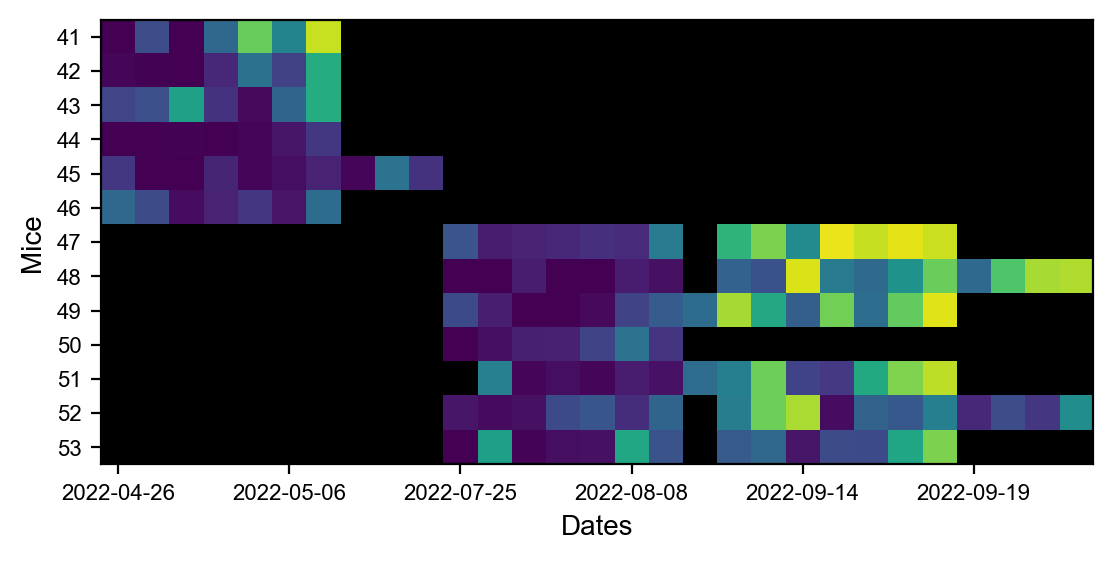

In [31]:
gr_df, out_list, ax, _ = ev_dataset.analyse_successrate([0], [1], bywhat='dates')

print(gr_df)

print(out_list)

ax.set_xticks(range(0, len(out_list[0].index), 5))
ax.set_xticklabels(out_list[0].index[range(0, len(out_list[0].index), 5)])
